# Graph Database Algorithm Implementation

### Congress Trading Analysis - Neo4J analysis, Redis & MongoDB Breakdown
Authors: Maxwell Bowman, William Crosby, Kobby Hanson, Yu-Sheng Lee

## Setup Environment and Helpers

### Import Modules

In [1]:
import os
import csv
import json
import math

# data wrangling
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt

# databases
import neo4j
import psycopg2

from IPython.display import display

### Supporting code to build pandas dataframe

In [2]:
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()

## Data Wrangling
The primary dataset for this analysis is sourced directly from the House Stock Watcher API (available at https://housestockwatcher.com/api), which provides structured access (via CSV or JSON) to financial transaction data disclosed by members of the U.S. House of Representatives. This dataset captures a range of information for each transaction, transcribed from official periodic transaction reports:

### Drop all transactions table if exists

In [5]:
# Drop Table if exists
connection.rollback()

query = """

DROP TABLE IF EXISTS all_transactions;

"""

cursor.execute(query)

connection.commit()

### Create Table if exists

In [6]:
# Create Table
query = """

CREATE TABLE all_transactions (
  stage_id SERIAL PRIMARY KEY,         -- Auto-incrementing ID for the row
  disclosure_year VARCHAR(100),        -- Year as integer
  disclosure_date VARCHAR(100),        -- Date in 'YYYY-MM-DD' format
  transaction_date VARCHAR(100),       -- Date in 'YYYY-MM-DD' format
  owner VARCHAR(50),                   -- Owner type (e.g., joint, individual)
  ticker VARCHAR(20),                  -- Stock ticker (e.g., BP)
  asset_description VARCHAR(255),      -- Asset description (e.g., BP plc)
  type VARCHAR(50),                    -- Type of transaction (e.g., purchase)
  amount VARCHAR(50),                  -- Amount as a string (e.g., $1,001 - $15,000)
  representative VARCHAR(100),         -- Representative name (e.g., Virginia Foxx)
  district VARCHAR(50),                -- District identifier (e.g., NC05)
  state VARCHAR(2),                    -- State abbreviation (e.g., NC)
  ptr_link VARCHAR(255),               -- URL link to document
  cap_gains_over_200_usd BOOLEAN,      -- Boolean indicating if there are capital gains over $200
  industry VARCHAR(100),               -- Industry category (e.g., Integrated oil Companies)
  sector VARCHAR(100),                 -- Sector (e.g., Energy)
  party VARCHAR(50)                    -- Political party (e.g., Republican)
);

"""
cursor.execute(query)
connection.commit()

### Import data from CSV

In [7]:
# Import Data
connection.rollback()
query = """

COPY all_transactions (
    disclosure_year,
    disclosure_date,
    transaction_date,
    owner,
    ticker,
    asset_description, 
    type,
    amount,
    representative,
    district,
    state,
    ptr_link,
    cap_gains_over_200_usd, 
    industry,
    sector,
    party
)
FROM '/user/projects/project-3-wcrosby-edu/data/all_transactions.csv'
DELIMITER ',' NULL '' CSV HEADER;

"""
cursor.execute(query)
connection.commit()

### Clean data values
- select columns of interest
- extract the low value, remove $, commas, +, and handle empty strings
- extract the high value, remove $, commas, and handle empty strings
- drop rows with corrupt/bad data ex: bad transaction date & blank sectors
  - 4k+ removed out of ~17k records

In [8]:
rollback_before_flag = True
rollback_after_flag = True

query = """
WITH dataset AS (
    SELECT DISTINCT 
        transaction_date,
        owner,
        ticker,
        asset_description,
        type,
        representative,
        district,
        state,
        cap_gains_over_200_usd,
        industry,
        sector,
        party,
        amount,

        -- extract the low value, remove $, commas, +, and handle empty strings
        CASE 
            WHEN amount LIKE '%+%' THEN 
                NULLIF(CAST(NULLIF(REPLACE(REPLACE(REPLACE(TRIM(amount), '$', ''), ',', ''), '+', ''), '') AS INTEGER), 0)
            WHEN amount LIKE '%-%' THEN 
                NULLIF(CAST(NULLIF(REPLACE(REPLACE(TRIM(SPLIT_PART(amount, '-', 1)), '$', ''), ',', ''), '') AS INTEGER), 0)
            ELSE NULL 
        END AS low,

        -- extract the high value, remove $, commas, and handle empty strings
        CASE 
            WHEN amount LIKE '%+%' THEN NULL
            WHEN amount LIKE '%-%' AND POSITION('-' IN amount) > 0 THEN 
                NULLIF(CAST(NULLIF(REPLACE(REPLACE(TRIM(SPLIT_PART(amount, '-', 2)), '$', ''), ',', ''), '') AS INTEGER), 0)
            ELSE NULL 
        END AS high

    FROM all_transactions
    WHERE sector IS NOT NULL
      AND sector != '' 
      AND LOWER(sector) != 'none'
)

SELECT *
FROM dataset
"""

df_clean = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_clean.to_csv("../data/cleaned_transaction.csv", index=False)
df_clean

,transaction_date,owner,ticker,asset_description,type,representative,district,state,cap_gains_over_200_usd,industry,sector,party,amount,low,high
0,7/7/20,None,USAC,"USA Compression Partners, LP Common Units Repr...",purchase,Mark E. Green,TN07,TN,False,Oilfield Services/Equipment,Energy,Republican,"$50,001 - $100,000",50001,100000
1,7/16/20,--,STOR,STORE Capital Corporation,sale_partial,Lois Frankel,FL21,FL,False,Real Estate Investment Trusts,Real Estate,Democrat,"$1,001 - $15,000",1001,15000
2,3/31/20,None,BA,Boeing Company,sale_full,John A. Yarmuth,KY03,KY,False,Aerospace,Capital Goods,Republican,"$1,001 - $15,000",1001,15000
3,1/13/22,joint,CVS,CVS Health Corporation,purchase,"Donald S. Beyer, Jr.",VA08,VA,False,Medical/Nursing Services,Health Care,Democrat,"$1,001 - $15,000",1001,15000
4,3/25/21,self,TOL,Toll Brothers Finance,purchase,Alan S. Lowenthal,CA47,CA,False,Homebuilding,Consumer Discretionary,Democrat,"$15,001 - $50,000",15001,50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11922,11/7/22,self,U,Unity Software Inc - Exchanged due to merged o...,exchange,Deborah Ross,NC02,NC,False,Retail: Computer Software & Peripheral Equipment,Technology,Democrat,"$1,001 - $15,000",1001,15000
11923,6/30/20,None,PGNY,"Progyny, Inc.",purchase,Gilbert Cisneros,CA39,CA,False,Managed Health Care,Health Care,Democrat,"$1,001 - $15,000",1001,15000
11924,3/14/22,None,VTRS,Viatris Inc,sale_full,Earl Blumenauer,OR03,OR,False,Major Pharmaceuticals,Health Care,Democrat,"$1,001 - $15,000",1001,15000
11925,5/27/20,None,INTC,Intel Corporation,purchase,Lois Frankel,FL21,FL,False,Semiconductors,Technology,Democrat,"$1,001 - $15,000",1001,15000


## Web server interface at https://xxxx:7473

**Username: neo4j**

**Password: ucb_mids_w205**

**In the web server interface, run the same query from last week to return all nodes and all relationships:**

```
match (n) return n
```

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11927 entries, 0 to 11926
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   transaction_date        11927 non-null  object
 1   owner                   7190 non-null   object
 2   ticker                  11927 non-null  object
 3   asset_description       11926 non-null  object
 4   type                    11927 non-null  object
 5   representative          11927 non-null  object
 6   district                11927 non-null  object
 7   state                   11927 non-null  object
 8   cap_gains_over_200_usd  11927 non-null  bool  
 9   industry                11927 non-null  object
 10  sector                  11927 non-null  object
 11  party                   11860 non-null  object
 12  amount                  11927 non-null  object
 13  low                     11927 non-null  int64 
 14  high                    11811 non-null  Int64 
dtypes:

# Algorithms

## Louvain Modularity

Louvain will try different grouping methods and assign the nodes to the best groupings based on their weights and densities, thereby measuring how well a node is assigned to a group. 

In our case, we use Louvain to summarize transactions into clusters and measure the similarity between these transactions based on their `industry`, `sector`, and political affiliation (`party` and `state`).

### Aggregate the data 

In [10]:

# Cleaning
rollback_before_flag = True
rollback_after_flag = True

query = """
WITH dataset AS (

    SELECT DISTINCT 
        transaction_date,
        owner,
        ticker,
        asset_description,
        type,
        representative,
        district,
        state,
        cap_gains_over_200_usd,
        industry,
        sector,
        party,
        amount,

        -- extract the low value, remove $, commas, +, and handle empty strings
        CASE 
            WHEN amount LIKE '%+%' THEN 
                NULLIF(CAST(NULLIF(REPLACE(REPLACE(REPLACE(TRIM(amount), '$', ''), ',', ''), '+', ''), '') AS INTEGER), 0)
            WHEN amount LIKE '%-%' THEN 
                NULLIF(CAST(NULLIF(REPLACE(REPLACE(TRIM(SPLIT_PART(amount, '-', 1)), '$', ''), ',', ''), '') AS INTEGER), 0)
            ELSE NULL 
        END AS low,

        -- extract the high value, remove $, commas, and handle empty strings
        CASE 
            WHEN amount LIKE '%+%' THEN NULL
            WHEN amount LIKE '%-%' AND POSITION('-' IN amount) > 0 THEN 
                NULLIF(CAST(NULLIF(REPLACE(REPLACE(TRIM(SPLIT_PART(amount, '-', 2)), '$', ''), ',', ''), '') AS INTEGER), 0)
            ELSE NULL 
        END AS high

    FROM all_transactions
    WHERE sector IS NOT NULL
      AND sector != '' 
      AND LOWER(sector) != 'none'
      AND transaction_date not in ('0009-06-09',
                                    '20221-11-18',
                                    '20222-11-16',
                                    '0201-06-22',
                                    '0022-11-23',
                                    '20222-07-18',
                                    '0023-01-11',
                                    '0021-06-22')
)

SELECT
    party,
    state,
    representative,
    sector,
    industry,
    ticker,
    count(*)
FROM dataset
group by
    party,
    state,
    representative,
    sector,
    industry,
    ticker
order by
    industry,
    sector,
    ticker,
    representative
"""

data = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
data.to_csv("../data/cleaned_transaction.csv", index=False)
data

,party,state,representative,sector,industry,ticker,count
0,Republican,WV,Carol Devine Miller,Finance,Accident &Health Insurance,AFL,1
1,Democrat,MN,Dean Phillips,Finance,Accident &Health Insurance,AFL,1
2,Democrat,CA,Gilbert Cisneros,Finance,Accident &Health Insurance,AFL,1
3,Republican,FL,John Rutherford,Finance,Accident &Health Insurance,AFL,1
4,Republican,GA,Marjorie Taylor Greene,Finance,Accident &Health Insurance,AFL,1
...,...,...,...,...,...,...,...
4594,Democrat,FL,Donna Shalala,Consumer Discretionary,Wholesale Distributors,PATK,2
4595,Democrat,CA,Gilbert Cisneros,Consumer Discretionary,Wholesale Distributors,PATK,1
4596,Democrat,NJ,Josh Gottheimer,Consumer Discretionary,Wholesale Distributors,PATK,1
4597,Democrat,FL,Donna Shalala,Consumer Discretionary,Wholesale Distributors,WSO,1


### Helper functions

In [11]:
# Functions
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [12]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

### Build the relationships

In [13]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")

In [14]:
# How many records to include
n = None
if type(n) == int:
    loaded_data = data.head(n)
else:
    loaded_data = data

def load_data(tx, df):
    for _, row in df.iterrows():
        tx.run("""
            MERGE (r:Representative {name: $rep}) SET r.party = $party, r.state = $state
            MERGE (c:Company {name: $ticker})
            MERGE (i:Industry {name: $industry})
            MERGE (s:Sector {name: $sector})
            // MERGE (p:Party {name: $party})
            
            MERGE (r)-[tr:TRADED]->(c) SET tr.count = $count
            MERGE (c)-[:BELONGS_TO_INDUSTRY]->(i)
            MERGE (i)-[:BELONGS_TO]->(s)
            // MERGE (r)-[:BELONGS_TO]->(p)
        """, 
        rep=row['representative'],
        party=row['party'],
        state=row['state'],
        sector=row['sector'],
        industry=row['industry'],
        ticker=row['ticker'],
        count=int(row['count']))  # Ensure count is an int

In [15]:
# Establish Neo4J driver
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))
session = driver.session(database="neo4j")
my_neo4j_wipe_out_database()

In [16]:
# Load into Neo4J
session.write_transaction(load_data, loaded_data)
print("All data loaded into Neo4j!")

/tmp/ipykernel_104/2264297702.py:2: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(load_data, loaded_data)


All data loaded into Neo4j!


### Create weighted similarity edges between Representatives

In [17]:
query = """
MATCH (r1:Representative)-[t1:TRADED]->(c:Company)<-[t2:TRADED]-(r2:Representative)
WHERE r1 <> r2
WITH r1, r2, t1.count AS c1, t2.count AS c2,
     CASE WHEN r1.party = r2.party THEN 1 ELSE 0 END AS sameParty
     // CASE WHEN r1.state = r2.state THEN 1 ELSE 0 END AS sameState
MERGE (r1)-[s:SIMILAR_TO]-(r2)
ON CREATE SET 
    s.weight = c1 + c2 + (sameParty * 5) //+ (sameState * 5)
ON MATCH SET 
    s.weight = s.weight + c1 + c2 + (sameParty * 5) //+ (sameState * 5)

"""
session.run(query)

### Take a peek at the similarity score

In [18]:
query = """
MATCH (r1:Representative)-[s:SIMILAR_TO]-(r2:Representative)
WHERE id(r1) < id(r2)  // avoid duplicate pairs (A-B and B-A)
RETURN 
    r1.name AS rep1, 
    r2.name AS rep2, 
    s.weight AS similarity
ORDER BY similarity DESC
"""
my_neo4j_run_query_pandas(query)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 16, offset: 77} for query: '\nMATCH (r1:Representative)-[s:SIMILAR_TO]-(r2:Representative)\nWHERE id(r1) < id(r2)  // avoid duplicate pairs (A-B and B-A)\nRETURN \n    r1.name AS rep1, \n    r2.name AS rep2, \n    s.weight AS similarity\nORDER BY similarity DESC\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 7, offset: 68} for query: '\nMATCH (r1:Representative)-[s:SIMILAR_TO]-(r2:Representative)\nWHERE id(r1) < 

,rep1,rep2,similarity
0,Gilbert Cisneros,Josh Gottheimer,3462
1,Dean Phillips,Gilbert Cisneros,1996
2,Josh Gottheimer,Kathy Manning,1696
3,Josh Gottheimer,Kurt Schrader,1492
4,Josh Gottheimer,Peter Meijer,1322
...,...,...,...
4819,Jonathan Jackson,Brian Higgins,4
4820,Peter Meijer,Brian Higgins,4
4821,Marjorie Taylor Greene,Brian Higgins,4
4822,Donna Shalala,Harold Dallas Rogers,4


### Create Graph Object to implement Louvain

In [19]:
query = """
CALL gds.graph.drop('rep-similarity', false);
"""
session.run(query)

query = """
CALL gds.graph.project(
    'rep-similarity',
    'Representative',
    {
        SIMILAR_TO: {
            properties: 'weight',
            orientation: 'UNDIRECTED'
        }
    }
);
"""
session.run(query)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 1} for query: "\nCALL gds.graph.drop('rep-similarity', false);\n"


### Summarize the data and return a resulting dataframe

In [20]:
query = """
CALL gds.louvain.stream('rep-similarity')
YIELD nodeId, communityId
WITH gds.util.asNode(nodeId) AS rep, communityId

// Get traded industries and sectors with counts
MATCH (rep)-[t:TRADED]->(:Company)-[:BELONGS_TO_INDUSTRY]->(ind:Industry)-[:BELONGS_TO]->(sec:Sector)
WITH rep, communityId,
     ind.name AS industryName,
     sec.name AS sectorName,
     SUM(t.count) AS tradeCount
ORDER BY rep.name, tradeCount DESC

// Group industries and sectors per rep by volume
WITH rep, communityId,
     collect({industry: industryName, trades: tradeCount})[0] AS topIndustry,
     collect({sector: sectorName, trades: tradeCount})[0] AS topSector

RETURN 
  rep.name AS representative,
  rep.party AS party,
//  rep.state AS state,
  communityId,
  topSector.sector AS mostTradedSector,
  topSector.trades AS sectorVolume,
  topIndustry.industry AS mostTradedIndustry,
  topIndustry.trades AS industryVolume
ORDER BY communityId desc, party, mostTradedSector, mostTradedIndustry;

"""
res = my_neo4j_run_query_pandas(query)
res

,representative,party,communityId,mostTradedSector,sectorVolume,mostTradedIndustry,industryVolume
0,Robert E. Latta,Republican,158,Finance,4,Savings Institutions,4
1,Tim Burchett,Republican,157,Consumer Services,1,Restaurants,1
2,James M. Costa,Republican,150,Finance,1,Major Banks,1
3,W. Gregory Steube,Democrat,149,Finance,13,Major Banks,13
4,Joseph P. Kennedy III,Democrat,146,Consumer Discretionary,1,Hotels/Resorts,1
...,...,...,...,...,...,...,...
157,Brian Mast,Republican,68,Health Care,7,Biotechnology: Pharmaceutical Preparations,7
158,Kenny Marchant,Republican,68,Health Care,12,Major Pharmaceuticals,12
159,Tom Cole,Republican,68,Health Care,2,Medical/Nursing Services,2
160,Victoria Spartz,Republican,68,Real Estate,15,Real Estate Investment Trusts,15


### Party Distribution By Community

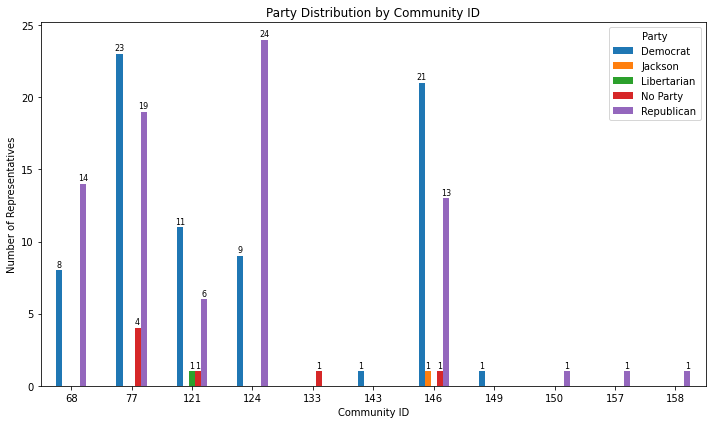

In [21]:
res['party'] = res['party'].fillna('No Party')
by_community_party = res.groupby(['communityId', 'party']).size().unstack(fill_value=0)

# Create the plot and get the Axes object
ax = by_community_party.plot(kind='bar', figsize=(10, 6))

plt.title('Party Distribution by Community ID')
plt.xlabel('Community ID')
plt.ylabel('Number of Representatives')
plt.xticks(rotation=0)
plt.legend(title='Party')
plt.tight_layout()

# Annotate each bar with its value
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.1,
                int(height),
                ha='center',
                va='bottom',
                fontsize=8
            )

# Save and show the figure
plt.savefig('../slides/Party Distribution by Community.png', dpi=300, bbox_inches='tight')
plt.show()


### Sector Distribution By Community

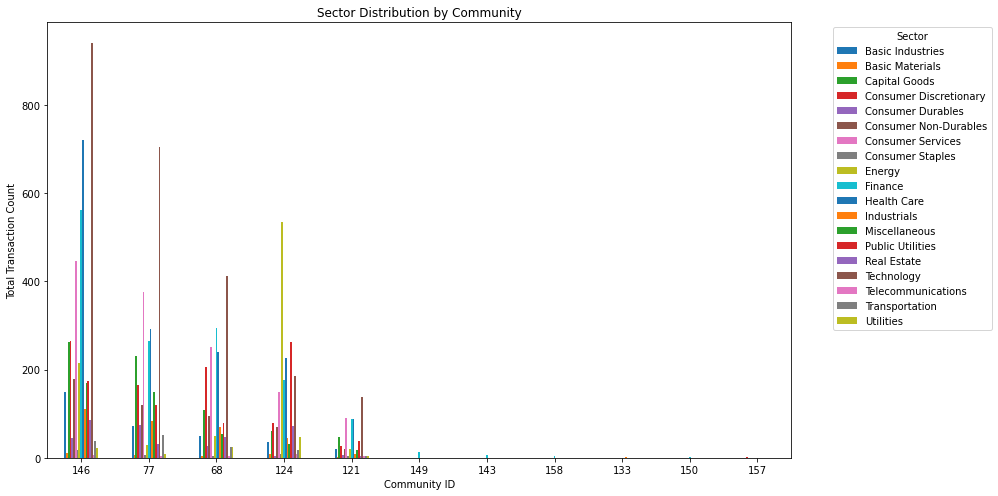

In [22]:
rep_party_map = res[['representative', 'party', 'communityId']].drop_duplicates()
cleaned_transactions = pd.read_csv('../data/cleaned_transaction.csv')
cleaned_transactions = cleaned_transactions.merge(
    rep_party_map,
    on='representative',
    how='left'  # keep all rows from cleaned_transactions
)

# Group by communityId and sector, summing the counts
df = cleaned_transactions[['communityId', 'sector', 'count']].groupby(by=['communityId', 'sector'])['count'].sum().unstack(fill_value=0)

# Optional: sort communities by total transaction count
df['Total'] = df.sum(axis=1)
df = df.sort_values('Total', ascending=False)
df = df.drop(columns='Total')  # drop total after sorting

# Plot as grouped bar chart
ax = df.plot(kind='bar', figsize=(14, 7))

plt.title('Sector Distribution by Community')
plt.xlabel('Community ID')
plt.ylabel('Total Transaction Count')
plt.xticks(rotation=0)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


# Save and show
plt.savefig('../slides/Sector Distribution by Community.png', dpi=300, bbox_inches='tight')
plt.show()

## Page Rank

### Prepare new session

In [23]:
# Rename the column 'type' to 'transaction_type' to avoid conflicts with reserved words
df_clean.rename(columns={"type": "transaction_type"}, inplace=True)
df_clean.rename(columns={"high": "max_amount"}, inplace=True)
display(df_clean.head())

,transaction_date,owner,ticker,asset_description,transaction_type,representative,district,state,cap_gains_over_200_usd,industry,sector,party,amount,low,max_amount
0,7/7/20,None,USAC,"USA Compression Partners, LP Common Units Repr...",purchase,Mark E. Green,TN07,TN,False,Oilfield Services/Equipment,Energy,Republican,"$50,001 - $100,000",50001,100000
1,7/16/20,--,STOR,STORE Capital Corporation,sale_partial,Lois Frankel,FL21,FL,False,Real Estate Investment Trusts,Real Estate,Democrat,"$1,001 - $15,000",1001,15000
2,3/31/20,None,BA,Boeing Company,sale_full,John A. Yarmuth,KY03,KY,False,Aerospace,Capital Goods,Republican,"$1,001 - $15,000",1001,15000
3,1/13/22,joint,CVS,CVS Health Corporation,purchase,"Donald S. Beyer, Jr.",VA08,VA,False,Medical/Nursing Services,Health Care,Democrat,"$1,001 - $15,000",1001,15000
4,3/25/21,self,TOL,Toll Brothers Finance,purchase,Alan S. Lowenthal,CA47,CA,False,Homebuilding,Consumer Discretionary,Democrat,"$15,001 - $50,000",15001,50000


### Create PageRank Table and Chart for Most Influential Representative
Graph Relationships Helper Function

In [24]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [25]:
session = driver.session(database="neo4j")

In [26]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [27]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")

In [28]:
# Clear any existing data
def clear_graph(tx):
    tx.run("MATCH (n) DETACH DELETE n")

with driver.session() as session:
    session.write_transaction(clear_graph)
print("Existing graph data cleared.")

Existing graph data cleared.


/tmp/ipykernel_104/381571526.py:6: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(clear_graph)


In [29]:
# Build Initial Nodes and Relationships
def create_nodes_and_relationships(tx, row):
    
# Create Representative node
    rep_query = """
    MERGE (r:Representative {name: $representative})
    ON CREATE SET r.party = $party, r.state = $state
    """
    tx.run(rep_query,
           representative=row['representative'],
           party=row['party'],
           state=row['state'])
    
    # Create Stock node
    stock_query = """
    MERGE (s:Stock {ticker: $ticker})
    ON CREATE SET s.sector = $sector
    """
    tx.run(stock_query,
           ticker=row['ticker'],
           sector=row['sector'])
    
    # Create the TRANSACTED relationship
    rel_query = """
    MATCH (r:Representative {name: $representative}), (s:Stock {ticker: $ticker})
    MERGE (r)-[rel:TRANSACTED]->(s)
    ON CREATE SET rel.max_amount = $max_amount, rel.types = [$transaction_type]
    ON MATCH SET rel.max_amount = rel.max_amount + $max_amount,
                 rel.types = rel.types + [$transaction_type]
    """
    tx.run(rel_query,
           representative=row['representative'],
           ticker=row['ticker'],
           max_amount=row['max_amount'],
           transaction_type=row['transaction_type'])

with driver.session() as session:
    for index, row in df_clean.iterrows():
        session.write_transaction(create_nodes_and_relationships, row)
print("Graph construction complete.")

/tmp/ipykernel_104/3346223899.py:39: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_nodes_and_relationships, row)


Graph construction complete.


### Begin PageRank Query

In [30]:
# Create the in-memory graph project
with driver.session() as session:
    session.run("""
    CALL gds.graph.project(
        'investmentGraph',
        ['Representative', 'Stock'],
        {
            TRANSACTED: {
                type: 'TRANSACTED',
                orientation: 'UNDIRECTED',
                properties: 'max_amount'
            }
        }
    ) YIELD graphName
    """)

,node_type,identifier,pageRank_score
0,Representative,Donna Shalala,49.793482
1,Representative,Gilbert Cisneros,47.339150
2,Representative,Josh Gottheimer,41.188630
3,Representative,Susie Lee,34.667938
4,Representative,Greg Gianforte,26.964508
5,Representative,Chris Jacobs,25.163189
6,Representative,Peter Meijer,22.962498
7,Representative,Dean Phillips,22.727701
8,Representative,Lois Frankel,19.696317
9,Representative,Zoe Lofgren,13.909558


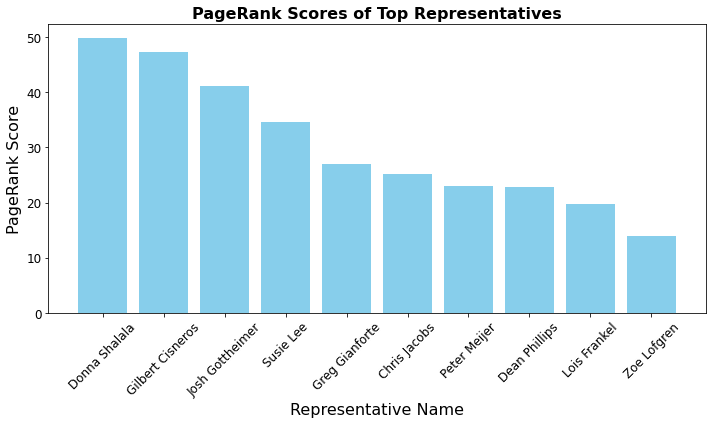

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('investmentGraph', false)"


In [31]:
# Run PageRank Algorithm
pagerank_query = """
CALL gds.pageRank.stream('investmentGraph', {maxIterations:20, dampingFactor:0.85})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId) AS node, score
ORDER BY score DESC
LIMIT 10
"""

results = []
with driver.session() as session:
    result = session.run(pagerank_query)
    for record in result:
        node = record["node"]
        score = record["score"]
        if "Representative" in list(node.labels):
            identifier = node.get("name")
            node_type = "Representative"
        elif "Stock" in list(node.labels):
            identifier = node.get("ticker")
            node_type = "Stock"
        else:
            identifier = "Unknown"
            node_type = "Unknown"
        results.append({"node_type": node_type, "identifier": identifier, "pageRank_score": score})

pagerank_df = pd.DataFrame(results)
display(pagerank_df)

plt.figure(figsize=(10,6))
plt.bar(pagerank_df['identifier'], pagerank_df['pageRank_score'], color='skyblue')
plt.title("PageRank Scores of Top Representatives", fontsize=16, fontweight="bold")
plt.xlabel("Representative Name", fontsize=16)
plt.ylabel("PageRank Score", fontsize=16)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

# Drop the in-memory graph project
with driver.session() as session:
    session.run("CALL gds.graph.drop('investmentGraph', false)")
    
driver.close()

Key Insight: It appears Donna Shalala might be a case of rank sink (trading in stocks not shared by others, creating a loop inflating her PageRank score).  She trades in a number of stocks no one else does while also being a fairly larger trader (She is number 17 in the list of largest dollar value traders below).

### Create a Table of Maximum Trading Value by Representative

In [32]:
# Group by Representative, Party, and sum Max_Amount
large_traders_df = df_clean.groupby(['representative', 'party']).agg(
    total_max_amount=('max_amount', 'sum'),
    transaction_count=('max_amount', 'count')
).reset_index()

# Sort the DataFrame in descending order by total_max_amount and then by representative
large_traders_df = large_traders_df.sort_values(by=['total_max_amount', 'representative'], ascending=[False, False])

# Reset the index so it reflects the new sorted order
large_traders_df = large_traders_df.reset_index(drop=True)


# Print the top 30 records
top_30 = large_traders_df.head(30)
display(top_30)

,representative,party,total_max_amount,transaction_count
0,Josh Gottheimer,Democrat,178910000,1220
1,Suzan K. DelBene,Democrat,164090000,19
2,Nancy Pelosi,Democrat,132780000,76
3,Mark E. Green,Republican,91930000,427
4,Kevin Hern,Republican,37080000,417
5,Michael T. McCaul,Republican,23960000,233
6,Greg Gianforte,Republican,20150000,217
7,Kim Schrier,Democrat,18000000,37
8,Scott Franklin,Republican,17850000,41
9,Van Taylor,Republican,16160000,29


Return all trading records for Representative Donna Shalala, include only stocks that she alone trades.

In [33]:
# For each ticker group, keep the group if the set of unique representatives is exactly {"Donna Shalala"}
Donna_df = df_clean.groupby("ticker").filter(lambda group: set(group["representative"]) == {"Donna Shalala"})

# Display the resulting table
display(Donna_df)

,transaction_date,owner,ticker,asset_description,transaction_type,representative,district,state,cap_gains_over_200_usd,industry,sector,party,amount,low,max_amount
1989,2/6/19,--,MSTR,MicroStrategy Incorporated - Class A,sale_full,Donna Shalala,FL27,FL,False,Computer Software: Prepackaged Software,Technology,Democrat,"$1,001 - $15,000",1001,15000
2026,1/23/19,--,EEFT,"Euronet Worldwide, Inc.",sale_full,Donna Shalala,FL27,FL,False,Investment Bankers/Brokers/Service,Finance,Democrat,"$1,001 - $15,000",1001,15000
2175,5/8/19,--,IONS,"Ionis Pharmaceuticals, Inc.",purchase,Donna Shalala,FL27,FL,False,Major Pharmaceuticals,Health Care,Democrat,"$1,001 - $15,000",1001,15000
2294,6/24/19,--,CDE,"Coeur Mining, Inc.",sale_full,Donna Shalala,FL27,FL,False,Precious Metals,Basic Materials,Democrat,"$1,001 - $15,000",1001,15000
2343,4/16/19,--,RDUS,"Radius Health, Inc.",purchase,Donna Shalala,FL27,FL,False,Major Pharmaceuticals,Health Care,Democrat,"$1,001 - $15,000",1001,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11686,4/30/19,--,ABM,ABM Industries Incorporated,sale_full,Donna Shalala,FL27,FL,False,Diversified Commercial Services,Consumer Discretionary,Democrat,"$1,001 - $15,000",1001,15000
11745,6/24/19,--,ADUS,Addus HomeCare Corporation,sale_full,Donna Shalala,FL27,FL,False,Medical/Nursing Services,Health Care,Democrat,"$1,001 - $15,000",1001,15000
11829,6/24/19,--,MPWR,"Monolithic Power Systems, Inc.",sale_full,Donna Shalala,FL27,FL,False,Semiconductors,Technology,Democrat,"$1,001 - $15,000",1001,15000
11890,1/23/19,--,PBYI,Puma Biotechnology Inc,purchase,Donna Shalala,FL27,FL,False,Biotechnology: Pharmaceutical Preparations,Health Care,Democrat,"$1,001 - $15,000",1001,15000


### Create PageRank Table and Chart for Most Influential Stock Ticker

In [34]:
# Clear any existing data
def clear_graph(tx):
    tx.run("MATCH (n) DETACH DELETE n")

with driver.session() as session:
    session.write_transaction(clear_graph)
print("Existing graph data cleared.")

/tmp/ipykernel_104/381571526.py:5: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/381571526.py:6: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(clear_graph)


Existing graph data cleared.


In [35]:
# Build Initial Nodes and Relationships
def create_nodes_and_relationships(tx, row):
    
# Create Representative node
    rep_query = """
    MERGE (r:Representative {name: $representative})
    ON CREATE SET r.party = $party, r.state = $state
    """
    tx.run(rep_query,
           representative=row['representative'],
           party=row['party'],
           state=row['state'])
    
    # Create Stock node
    stock_query = """
    MERGE (s:Stock {ticker: $ticker})
    ON CREATE SET s.sector = $sector
    """
    tx.run(stock_query,
           ticker=row['ticker'],
           sector=row['sector'])
    
    # Create the TRANSACTED relationship
    rel_query = """
    MATCH (r:Representative {name: $representative}), (s:Stock {ticker: $ticker})
    MERGE (r)-[rel:TRANSACTED]->(s)
    ON CREATE SET rel.max_amount = $max_amount, rel.types = [$transaction_type]
    ON MATCH SET rel.max_amount = rel.max_amount + $max_amount,
                 rel.types = rel.types + [$transaction_type]
    """
    tx.run(rel_query,
           representative=row['representative'],
           ticker=row['ticker'],
           max_amount=row['max_amount'],
           transaction_type=row['transaction_type'])

with driver.session() as session:
    for index, row in df_clean.iterrows():
        session.write_transaction(create_nodes_and_relationships, row)
print("Graph construction complete.")

/tmp/ipykernel_104/3346223899.py:37: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/3346223899.py:39: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_nodes_and_relationships, row)


Graph construction complete.


/tmp/ipykernel_104/2265672171.py:3: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/2265672171.py:30: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


,ticker,pageRank_score
0,AAPL,5.951321
1,MSFT,5.713277
2,AMZN,5.043663
3,DIS,3.687384
4,JPM,3.676358
5,T,3.596813
6,JNJ,3.590079
7,FB,3.580701
8,TSLA,3.238625
9,PG,2.997150


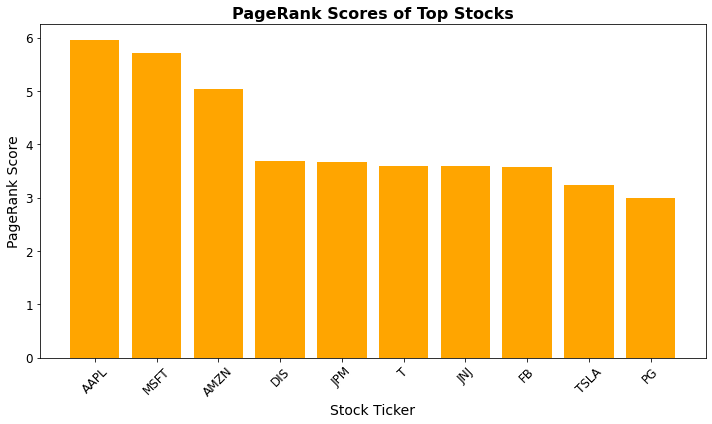

/tmp/ipykernel_104/2265672171.py:53: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('investmentGraph', false)"


In [36]:
# Begin PageRank Query (Analysis by Ticker)
# Create the in-memory graph project
with driver.session() as session:
    session.run("""
    CALL gds.graph.project(
        'investmentGraph',
        ['Representative', 'Stock'],
        {
            TRANSACTED: {
                type: 'TRANSACTED',
                orientation: 'UNDIRECTED',
                properties: 'max_amount'
            }
        }
    ) YIELD graphName
    """)

# Run PageRank Algorithm and filter only the Stock nodes.
pagerank_stocks_query = """
CALL gds.pageRank.stream('investmentGraph', {maxIterations:20, dampingFactor:0.85})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Stock' IN labels(node)
RETURN node.ticker AS ticker, score
ORDER BY score DESC
LIMIT 10
"""

results = []
with driver.session() as session:
    result = session.run(pagerank_stocks_query)
    for record in result:
        results.append({
            "ticker": record["ticker"],
            "pageRank_score": record["score"]
        })

pagerank_stocks_df = pd.DataFrame(results)
display(pagerank_stocks_df)

# Plot the Top Stock PageRank Scores
plt.figure(figsize=(10,6))
plt.bar(pagerank_stocks_df['ticker'], pagerank_stocks_df['pageRank_score'], color='orange')
plt.title("PageRank Scores of Top Stocks", fontsize=16, fontweight="bold")
plt.xlabel("Stock Ticker", fontsize=14)
plt.ylabel("PageRank Score", fontsize=14)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

# Drop the in-memory Stock graph
with driver.session() as session:
    session.run("CALL gds.graph.drop('investmentGraph', false)")

driver.close()

### Create PageRank Table and Chart for Most Influential Sector

In [37]:
# Clear any existing data
def clear_graph(tx):
    tx.run("MATCH (n) DETACH DELETE n")

with driver.session() as session:
    session.write_transaction(clear_graph)
print("Existing graph data cleared.")

Existing graph data cleared.


/tmp/ipykernel_104/381571526.py:5: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/381571526.py:6: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(clear_graph)


In [38]:
# Build Initial Nodes and Relationships
def create_nodes_and_relationships(tx, row):
    
# Create Representative node
    rep_query = """
    MERGE (r:Representative {name: $representative})
    ON CREATE SET r.party = $party, r.state = $state
    """
    tx.run(rep_query,
           representative=row['representative'],
           party=row['party'],
           state=row['state'])
    
    # Create Stock node
    stock_query = """
    MERGE (s:Stock {ticker: $ticker})
    ON CREATE SET s.sector = $sector
    """
    tx.run(stock_query,
           ticker=row['ticker'],
           sector=row['sector'])
    
    # Create the TRANSACTED relationship
    rel_query = """
    MATCH (r:Representative {name: $representative}), (s:Stock {ticker: $ticker})
    MERGE (r)-[rel:TRANSACTED]->(s)
    ON CREATE SET rel.max_amount = $max_amount, rel.types = [$transaction_type]
    ON MATCH SET rel.max_amount = rel.max_amount + $max_amount,
                 rel.types = rel.types + [$transaction_type]
    """
    tx.run(rel_query,
           representative=row['representative'],
           ticker=row['ticker'],
           max_amount=row['max_amount'],
           transaction_type=row['transaction_type'])

with driver.session() as session:
    for index, row in df_clean.iterrows():
        session.write_transaction(create_nodes_and_relationships, row)
print("Graph construction complete.")

/tmp/ipykernel_104/3346223899.py:37: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/3346223899.py:39: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_nodes_and_relationships, row)


Graph construction complete.


/tmp/ipykernel_104/4223682363.py:3: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: '\n    CALL gds.graph.project.cypher(\n      \'investmentGraph\',\n      "MATCH (n) WHERE n:Representative OR n:Stock RETURN id(n) as id, labels(n) AS labels",\n      "MATCH (r:Representative)-[rel:TRANSACTED]->(s:Stock) RETURN id(r) as source, id(s) as target, rel.max_amount as max_amount"\n    ) YIELD graphName\n    '
/tmp/ipykernel_104/4223682363.p

,sector,score
0,Technology,35.374223
1,Health Care,33.551799
2,Finance,31.217846
3,Consumer Discretionary,26.269090
4,Consumer Services,18.140631
5,Energy,14.260373
6,Industrials,11.785036
7,Capital Goods,9.692210
8,Real Estate,9.457599
9,Public Utilities,7.746180


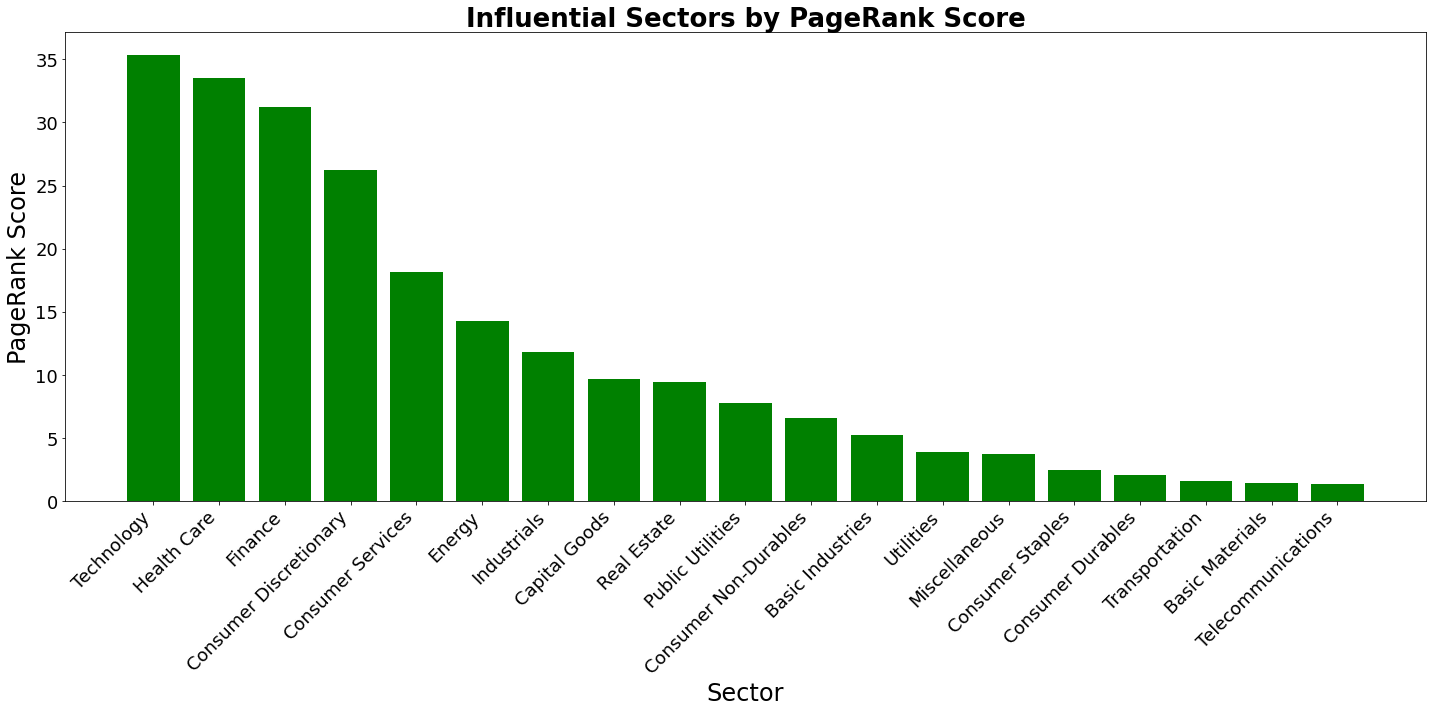

/tmp/ipykernel_104/4223682363.py:70: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('investmentGraph', false)"


In [39]:
# Begin PageRank Query (Analysis by Sector)
# Create the in-memory graph project
with driver.session() as session:
    session.run("""
    CALL gds.graph.project.cypher(
      'investmentGraph',
      "MATCH (n) WHERE n:Representative OR n:Stock RETURN id(n) as id, labels(n) AS labels",
      "MATCH (r:Representative)-[rel:TRANSACTED]->(s:Stock) RETURN id(r) as source, id(s) as target, rel.max_amount as max_amount"
    ) YIELD graphName
    """)

# Create PageRank for Stock nodes
pagerank_query = """
CALL gds.pageRank.stream('investmentGraph', {maxIterations:20, dampingFactor:0.85})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Stock' IN labels(node)
RETURN id(node) AS id, node.ticker AS ticker, score
"""

pagerank_results = []
with driver.session() as session:
    result = session.run(pagerank_query)
    for record in result:
        pagerank_results.append({
            "id": record["id"],
            "ticker": record["ticker"],
            "score": record["score"]
        })

pagerank_sector_df = pd.DataFrame(pagerank_results)
#display(pagerank_sector_df)

# Retrieve Sector Information from the Persistent Graph
sector_query = "MATCH (s:Stock) RETURN id(s) AS id, s.sector AS sector"
sectors = []
with driver.session() as session:
    result = session.run(sector_query)
    for record in result:
        sectors.append({
            "id": record["id"],
            "sector": record["sector"]
        })

sectors_df = pd.DataFrame(sectors)
#display(sectors_df)

# Combine the PageRank Stock Results with Sectors
merged_sectors_df = pd.merge(pagerank_sector_df, sectors_df, on="id")
#display(merged_sectors_df)

# Group the PageRank Scores by Sector
# Sum the PageRank scores for each Sector
sector_group = merged_sectors_df.groupby("sector")["score"].sum().reset_index()
sector_group = sector_group.sort_values(by="score", ascending=False).reset_index(drop=True)
display(sector_group)

# Create PageRank by Sector Bar Chart
plt.figure(figsize=(20,10))
plt.bar(sector_group["sector"], sector_group["score"], color='green')
plt.title("Influential Sectors by PageRank Score", fontsize=26, fontweight="bold")
plt.xlabel("Sector", fontsize=24)
plt.ylabel("PageRank Score", fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

# Drop the In-Memory Sector graph
with driver.session() as session:
    session.run("CALL gds.graph.drop('investmentGraph', false)")

driver.close()

### Create PageRank Table and Chart for Most Influential Stock Ticker For Democrats

In [40]:
# Clear any existing data
def clear_graph(tx):
    tx.run("MATCH (n) DETACH DELETE n")

with driver.session() as session:
    session.write_transaction(clear_graph)
print("Existing graph data cleared.")

Existing graph data cleared.


/tmp/ipykernel_104/381571526.py:5: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/381571526.py:6: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(clear_graph)


In [41]:
# Build Initial Nodes and Relationships
def create_nodes_and_relationships(tx, row):
    
# Create Representative node
    rep_query = """
    MERGE (r:Representative {name: $representative})
    ON CREATE SET r.party = $party, r.state = $state
    """
    tx.run(rep_query,
           representative=row['representative'],
           party=row['party'],
           state=row['state'])
    
    # Create Stock node
    stock_query = """
    MERGE (s:Stock {ticker: $ticker})
    ON CREATE SET s.sector = $sector
    """
    tx.run(stock_query,
           ticker=row['ticker'],
           sector=row['sector'])
    
    # Create the TRANSACTED relationship
    rel_query = """
    MATCH (r:Representative {name: $representative}), (s:Stock {ticker: $ticker})
    MERGE (r)-[rel:TRANSACTED]->(s)
    ON CREATE SET rel.max_amount = $max_amount, rel.types = [$transaction_type]
    ON MATCH SET rel.max_amount = rel.max_amount + $max_amount,
                 rel.types = rel.types + [$transaction_type]
    """
    tx.run(rel_query,
           representative=row['representative'],
           ticker=row['ticker'],
           max_amount=row['max_amount'],
           transaction_type=row['transaction_type'])

with driver.session() as session:
    for index, row in df_clean.iterrows():
        session.write_transaction(create_nodes_and_relationships, row)
print("Graph construction complete.")

/tmp/ipykernel_104/3346223899.py:37: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/tmp/ipykernel_104/3346223899.py:39: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_nodes_and_relationships, row)


Graph construction complete.


/tmp/ipykernel_104/142068790.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: '\n    CALL gds.graph.project.cypher(\n      \'investmentGraphDem\',\n      "MATCH (r:Representative) WHERE r.party = \'Democrat\'\n       RETURN id(r) AS id, labels(r) AS labels\n       UNION\n       MATCH (s:Stock) \n       RETURN id(s) AS id, labels(s) AS labels",\n      "MATCH (r:Representative)-[rel:TRANSACTED]->(s:Stock)\n       WHERE r.party = \

Created graph projection:  investmentGraphDem


/tmp/ipykernel_104/142068790.py:30: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


,ticker,pageRank_score
0,MSFT,0.482484
1,LHX,0.424035
2,GE,0.370124
3,AAPL,0.325336
4,TSLA,0.319411
5,MAR,0.284844
6,ATVI,0.283188
7,ZM,0.279906
8,ALL,0.279036
9,SHOP,0.277967


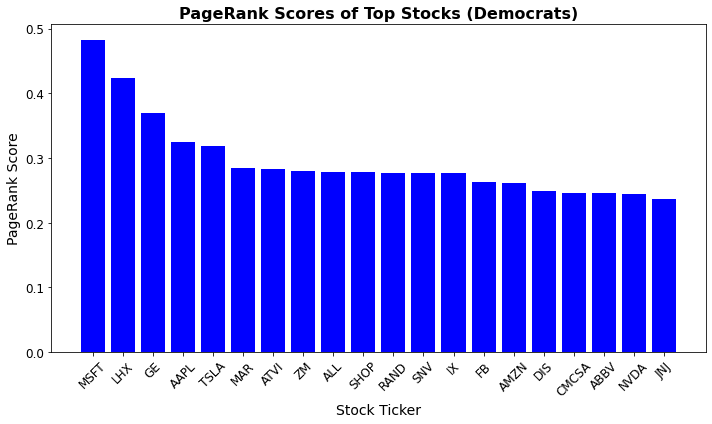

/tmp/ipykernel_104/142068790.py:52: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('investmentGraphDem', false)"


In [42]:
# Create a PageRank view for the Democrats
with driver.session() as session:
    result = session.run("""
    CALL gds.graph.project.cypher(
      'investmentGraphDem',
      "MATCH (r:Representative) WHERE r.party = 'Democrat'
       RETURN id(r) AS id, labels(r) AS labels
       UNION
       MATCH (s:Stock) 
       RETURN id(s) AS id, labels(s) AS labels",
      "MATCH (r:Representative)-[rel:TRANSACTED]->(s:Stock)
       WHERE r.party = 'Democrat'
       RETURN id(r) AS source, id(s) AS target, rel.max_amount AS max_amount"
    ) YIELD graphName
    """)
    for record in result:
        print("Created graph projection: ", record["graphName"])
    
# Create PageRank on the Democrat projection, returning only Stock nodes
pagerank_dem_query = """
CALL gds.pageRank.stream('investmentGraphDem', {maxIterations:20, dampingFactor:0.85})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Stock' IN labels(node)
RETURN node.ticker AS ticker, score
ORDER BY score DESC
LIMIT 20
"""
dem_results = []
with driver.session() as session:
    result = session.run(pagerank_dem_query)
    for record in result:
        dem_results.append({
            "ticker": record["ticker"],
            "pageRank_score": record["score"]
        })

pagerank_dem_df = pd.DataFrame(dem_results)
display(pagerank_dem_df)

plt.figure(figsize=(10,6))
plt.bar(pagerank_dem_df['ticker'], pagerank_dem_df['pageRank_score'], color='blue')
plt.title("PageRank Scores of Top Stocks (Democrats)", fontsize=16, fontweight="bold")
plt.xlabel("Stock Ticker", fontsize=14)
plt.ylabel("PageRank Score", fontsize=14)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

# Drop the in-memory Democrat Stock graph project
with driver.session() as session:
    session.run("CALL gds.graph.drop('investmentGraphDem', false)")

### Create PageRank Table and Chart for Most Influential Stock Ticker For Republicans

/tmp/ipykernel_104/1892202127.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: '\n    CALL gds.graph.project.cypher(\n      \'investmentGraphRep\',\n      "MATCH (r:Representative) WHERE r.party = \'Republican\'\n       RETURN id(r) AS id, labels(r) AS labels\n       UNION\n       MATCH (s:Stock) \n       RETURN id(s) AS id, labels(s) AS labels",\n      "MATCH (r:Representative)-[rel:TRANSACTED]->(s:Stock)\n       WHERE r.party 

Created graph projection:  investmentGraphRep


/tmp/ipykernel_104/1892202127.py:30: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


,ticker,pageRank_score
0,AMZN,0.436234
1,TSLA,0.423010
2,T,0.411617
3,AAPL,0.407716
4,WFC,0.367562
5,ABBV,0.307518
6,D,0.294941
7,XOM,0.285004
8,VZ,0.284978
9,PAA,0.283574


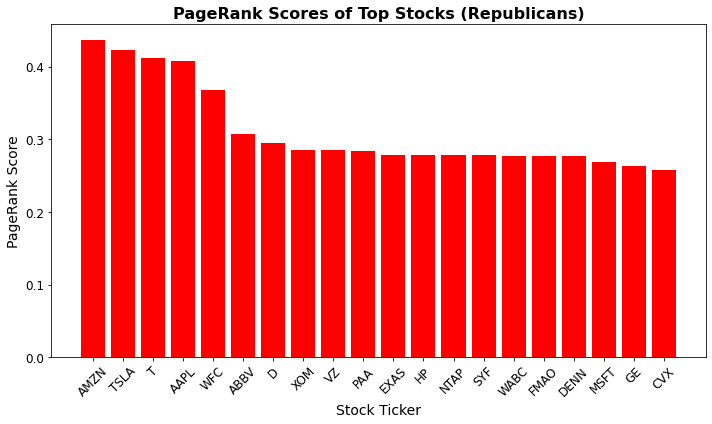

/tmp/ipykernel_104/1892202127.py:52: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('investmentGraphRep', false)"


In [43]:
# Create a PageRank view for the Republicans
with driver.session() as session:
    result = session.run("""
    CALL gds.graph.project.cypher(
      'investmentGraphRep',
      "MATCH (r:Representative) WHERE r.party = 'Republican'
       RETURN id(r) AS id, labels(r) AS labels
       UNION
       MATCH (s:Stock) 
       RETURN id(s) AS id, labels(s) AS labels",
      "MATCH (r:Representative)-[rel:TRANSACTED]->(s:Stock)
       WHERE r.party = 'Republican'
       RETURN id(r) AS source, id(s) AS target, rel.max_amount AS max_amount"
    ) YIELD graphName
    """)
    for record in result:
        print("Created graph projection: ", record["graphName"])

# Create PageRank on the Republican projection, returning only Stock nodes        
pagerank_rep_query = """
CALL gds.pageRank.stream('investmentGraphRep', {maxIterations:20, dampingFactor:0.85})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Stock' IN labels(node)
RETURN node.ticker AS ticker, score
ORDER BY score DESC
LIMIT 20
"""
rep_results = []
with driver.session() as session:
    result = session.run(pagerank_rep_query)
    for record in result:
        rep_results.append({
            "ticker": record["ticker"],
            "pageRank_score": record["score"]
        })

pagerank_rep_df = pd.DataFrame(rep_results)
display(pagerank_rep_df)

plt.figure(figsize=(10,6))
plt.bar(pagerank_rep_df['ticker'], pagerank_rep_df['pageRank_score'], color='red')
plt.title("PageRank Scores of Top Stocks (Republicans)", fontsize=16, fontweight="bold")
plt.xlabel("Stock Ticker", fontsize=14)
plt.ylabel("PageRank Score", fontsize=14)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

# Drop the in-memory RepuStock graph project
with driver.session() as session:
    session.run("CALL gds.graph.drop('investmentGraphRep', false)")

### Create PageRank Table and Chart for Most Influential Stock Ticker - Combined Democrats and Republicans

,ticker,pageRank_score,party
0,MSFT,0.482484,Democrat
1,LHX,0.424035,Democrat
2,GE,0.370124,Democrat
3,AAPL,0.325336,Democrat
4,TSLA,0.319411,Democrat
5,MAR,0.284844,Democrat
6,ATVI,0.283188,Democrat
7,ZM,0.279906,Democrat
8,ALL,0.279036,Democrat
9,SHOP,0.277967,Democrat


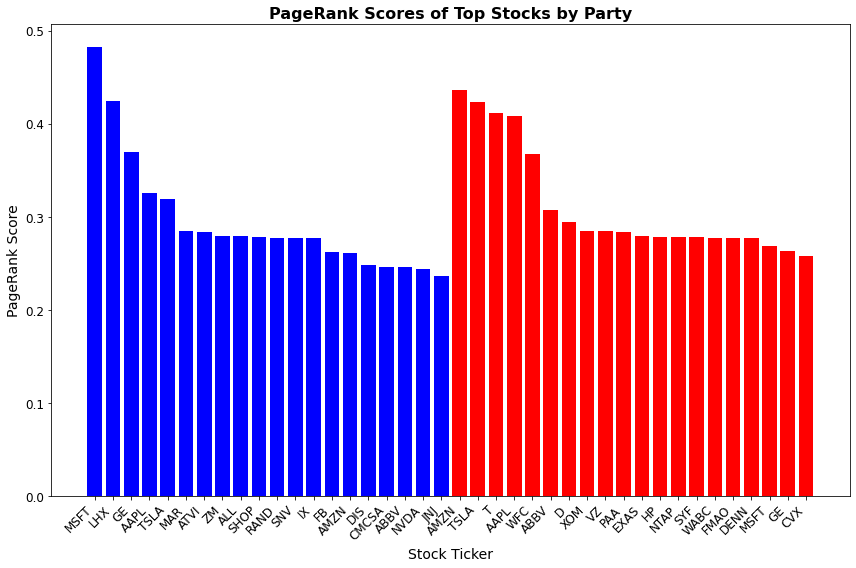

In [44]:
# Combine PageRank results for Democrats and Republicans and display side by side
# Add a party column to each DataFrame
pagerank_dem_df['party'] = 'Democrat'
pagerank_rep_df['party'] = 'Republican'

# Combine the results into one DataFrame
pagerank_demrep_df = pd.concat([pagerank_dem_df, pagerank_rep_df], ignore_index=True)

# Sort by party and then by PageRank score
pagerank_demrep_df = pagerank_demrep_df.sort_values(by=['party', 'pageRank_score'], ascending=[True, False])
display(pagerank_demrep_df)

# Create the Combined Bar Chart
plt.figure(figsize=(12, 8))
# Create a position for each bar
x_positions = np.arange(len(pagerank_demrep_df))
# Map party to a color: blue for Democrat, red for Republican
party_colors = pagerank_demrep_df['party'].map({'Democrat': 'blue', 'Republican': 'red'})

plt.bar(x_positions, pagerank_demrep_df['pageRank_score'], color=party_colors)

# Label each bar with its ticker
plt.xticks(x_positions, pagerank_demrep_df['ticker'], rotation=45, ha='right')
plt.xlabel("Stock Ticker", fontsize=14)
plt.ylabel("PageRank Score", fontsize=14)
plt.title("PageRank Scores of Top Stocks by Party", fontsize=16, fontweight="bold")
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

Identify tickers common to both Democrats and Republicans

In [45]:
# Create table of results
# Add a party column to each DataFrame:
pagerank_dem_df['party'] = 'Democrat'
pagerank_rep_df['party'] = 'Republican'

# Create a combined DataFrame with all results
combined_df = pd.concat([pagerank_dem_df, pagerank_rep_df], ignore_index=True)
display(combined_df)

# Identify common tickers across both parties
common_tickers = set(pagerank_dem_df['ticker']) & set(pagerank_rep_df['ticker'])
print("Common tickers:", common_tickers)

# Filter combined_df to only include rows where ticker is common to both parties
filtered_df = combined_df[combined_df['ticker'].isin(common_tickers)]
display(filtered_df)

# Pivot so that we have one row per ticker with separate columns for Democrat and Republican scores.
pivot_df = filtered_df.pivot(index="ticker", columns="party", values="pageRank_score")

# Fill missing values with 0 if any exist
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reset_index()
display(pivot_df)

,ticker,pageRank_score,party
0,MSFT,0.482484,Democrat
1,LHX,0.424035,Democrat
2,GE,0.370124,Democrat
3,AAPL,0.325336,Democrat
4,TSLA,0.319411,Democrat
5,MAR,0.284844,Democrat
6,ATVI,0.283188,Democrat
7,ZM,0.279906,Democrat
8,ALL,0.279036,Democrat
9,SHOP,0.277967,Democrat


Common tickers: {'AMZN', 'MSFT', 'TSLA', 'GE', 'AAPL', 'ABBV'}


,ticker,pageRank_score,party
0,MSFT,0.482484,Democrat
2,GE,0.370124,Democrat
3,AAPL,0.325336,Democrat
4,TSLA,0.319411,Democrat
14,AMZN,0.261006,Democrat
17,ABBV,0.246325,Democrat
20,AMZN,0.436234,Republican
21,TSLA,0.423010,Republican
23,AAPL,0.407716,Republican
25,ABBV,0.307518,Republican


party,ticker,Democrat,Republican
0,AAPL,0.325336,0.407716
1,ABBV,0.246325,0.307518
2,AMZN,0.261006,0.436234
3,GE,0.370124,0.262948
4,MSFT,0.482484,0.268557
5,TSLA,0.319411,0.423010


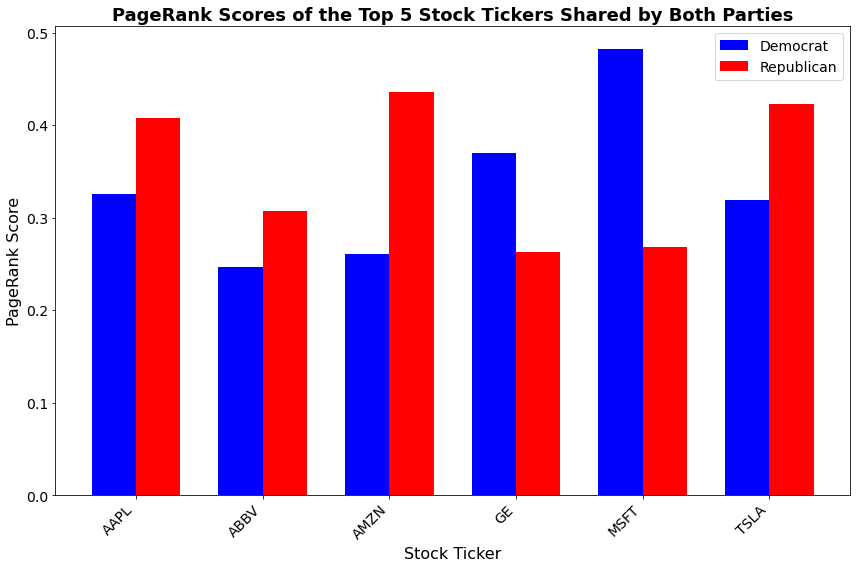

In [46]:
# Create a Grouped Bar Chart for Shared Tickers
fig, ax = plt.subplots(figsize=(12,8))

# X-axis positions for each common ticker
tickers = pivot_df['ticker'].tolist()
x = np.arange(len(tickers))
width = 0.35  # the width of each bar

# Plot Democrat bars (if exists)
if 'Democrat' in pivot_df.columns:
    ax.bar(x - width/2, pivot_df['Democrat'], width, label="Democrat", color="blue")

# Plot Republican bars (if exists)
if 'Republican' in pivot_df.columns:
    ax.bar(x + width/2, pivot_df['Republican'], width, label="Republican", color="red")

ax.set_xticks(x)
ax.set_xticklabels(tickers, rotation=45, ha='right', fontsize=14)
ax.set_xlabel("Stock Ticker", fontsize=16)
ax.set_ylabel("PageRank Score", fontsize=16)
ax.set_title("PageRank Scores of the Top 5 Stock Tickers Shared by Both Parties", fontsize=18, fontweight="bold")
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

## Betweenness Algorithm

Prepare the session

In [47]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [48]:
session = driver.session(database="neo4j")

In [49]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [50]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

### Builld the relationships & Query

In [51]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

In [52]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Station', {TRACK: {properties: 'track_miles'}})"
session.run(query)

In [53]:
query = """

CALL gds.betweenness.stream('ds_graph', {relationshipWeightProperty: 'track_miles'})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as betweenness
ORDER BY betweenness DESC

"""

my_neo4j_run_query_pandas(query)

,name,betweenness


In [54]:
def create_graph_from_df(df):

    my_neo4j_wipe_out_database()


    with driver.session() as session:
        for index, row in df.iterrows():
            session.run("""
                MERGE (r:Representative {name: $rep})
                MERGE (c:Company {ticker: $ticker})
                MERGE (r)-[:PURCHASED {type: $type, amount: $amount, date: $date}]->(c)
            """, {
                "rep": row["representative"],
                "ticker": row["ticker"],
                "type": row["type"],
                "amount": row["amount"],
                "date": row["transaction_date"]
            })

In [55]:
import pandas as pd

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from all_transactions

order by transaction_date desc
"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)


df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)


create_graph_from_df(df)

## Scenarios

### Redis

Redis' speed makes it ideal for real-time tracking of Congressional trading activity, directly addressing questions like "What congress people have made the most trades?" or "What companies are most traded?". For interactivity and responsiveness our financial analysis could be made into a dashboard using Redis implementation. This could feature:

- Leaderboards: Use Sorted Sets to maintain real-time rankings. Examples include:
  - Leaderboard, representative, trades: Score = transaction count, Member = representative name.
  - Leaderboard, asset, trades: Score = transaction count, Member = ticker symbol.
  - Leaderboard, sector, volume: Score = estimated total transaction volume (e.g., using midpoint of amount range), Member = sector name.
- Activity Counters: Use simple Keys to track recent activity: 
  - Activity, daily, sector increasing counter for trades within a sector each day.
  - Activity, hourly, overall: Counter for total transactions in the last hour.

This provides an immediate, low-latency view of trading hotspots and key actors, useful for dashboards or alert systems monitoring Congressional financial flows. Redis could also cache frequently queried data, like a representative's basic profile and party affiliation to accelerate related applications.


## MongoDB

MongoDB's point of view model offers flexibility for exploring the dataset from various angles. It can handle the data's variability and support queries related to different aspects like party, representative, and asset. A MongoDB scenario could involve:

- Representative POV: Store each Representative as a document with their profile information (name, district, state, party affiliation) and an embedded array of their transactions. This makes it easy to retrieve and analyze the complete trading history and patterns of individual members.
- Asset POV: Structure data around Assets (tickers), where each document includes asset details (ticker, name, sector, industry) and lists or aggregates information about the representatives who traded it. This helps answer questions like "What companies are most traded?" and analyze partisan preferences for specific stocks (such as "Do Democrats invest in Tesla more than Republicans?").
- Flexible Querying: Use MongoDB's query language and aggregation framework to explore complex questions that combine different aspects. For example: add up estimated purchase amounts by party and sector for a given year; find all sale transactions above a certain amount within a specific industry made by members of a particular party.